In [1]:
## Environment: conda env:tf212gpu
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain, plot_results
from exp_hp import get_hp

Num GPUs Available:  0


### Fuctions

In [ ]:
# ---------------- LEARNING RATE CALLBACK FUNCTION ----------------
# def scheduler(epoch, lr):
#     # This function keeps the initial learning rate for the first ten epochs
#     # and decreases it exponentially after that.
#     if epoch < 30:
#         return lr
#     else:
#         return lr * tf.constant(.1,dtype=tf.float32)

In [4]:
def create_ann2(input_shape,output_shape, hiddens, RIDGE = 0, dropout = True, dropout_rate = 0.0):
    tf.keras.backend.clear_session() 

    # ----- input of cnn -----
    ann_input = keras.Input(shape = input_shape)

    for l,layer in enumerate(hiddens):
        # ----- ann layers -----
        if l == 0:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=RIDGE),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(ann_input)
            if dropout:
                x = layers.Dropout(rate = dropout_rate)(x)
        else:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(output_shape,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')
    
    return ann

In [5]:
EXP_NAME2 = 'exp1_retrain'
hps2 = get_hp(EXP_NAME2)
EXP_NAME = 'exp1'
hps = get_hp(EXP_NAME)

print('Training Members: '+str(hps2['train_mems']))
print('Validation Member: '+str(hps2['val_mems'][0]))
print('Testing Member: '+str(hps2['test_mems'][0]))
print('Lead: '+str(hps2['LEAD']))
print('Region: '+str(hps2['region'][0])+'N x '+str(hps2['region'][1])+'E')

X2train, X2val, _, Y2train, Y2val, _, _ = split_retrain(trainmems = hps2['train_mems'],
                                                          valmem = hps2['val_mems'][0],
                                                          testmem = hps2['test_mems'][0],
                                                          months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                          lead = hps2['LEAD']) # 330 or 210

X2val = X2val.reshape((X2val.shape[0],X2val.shape[1]*X2val.shape[2]))
X2train = X2train.reshape((X2train.shape[0],X2train.shape[1]*X2train.shape[2]))
input_shape = X2train.shape[1]

Training Members: ['0201', '0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281']
Validation Member: 0291
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
loading data & saving


0


2024-08-06 11:29:19.820212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time during fit = 66.06 seconds



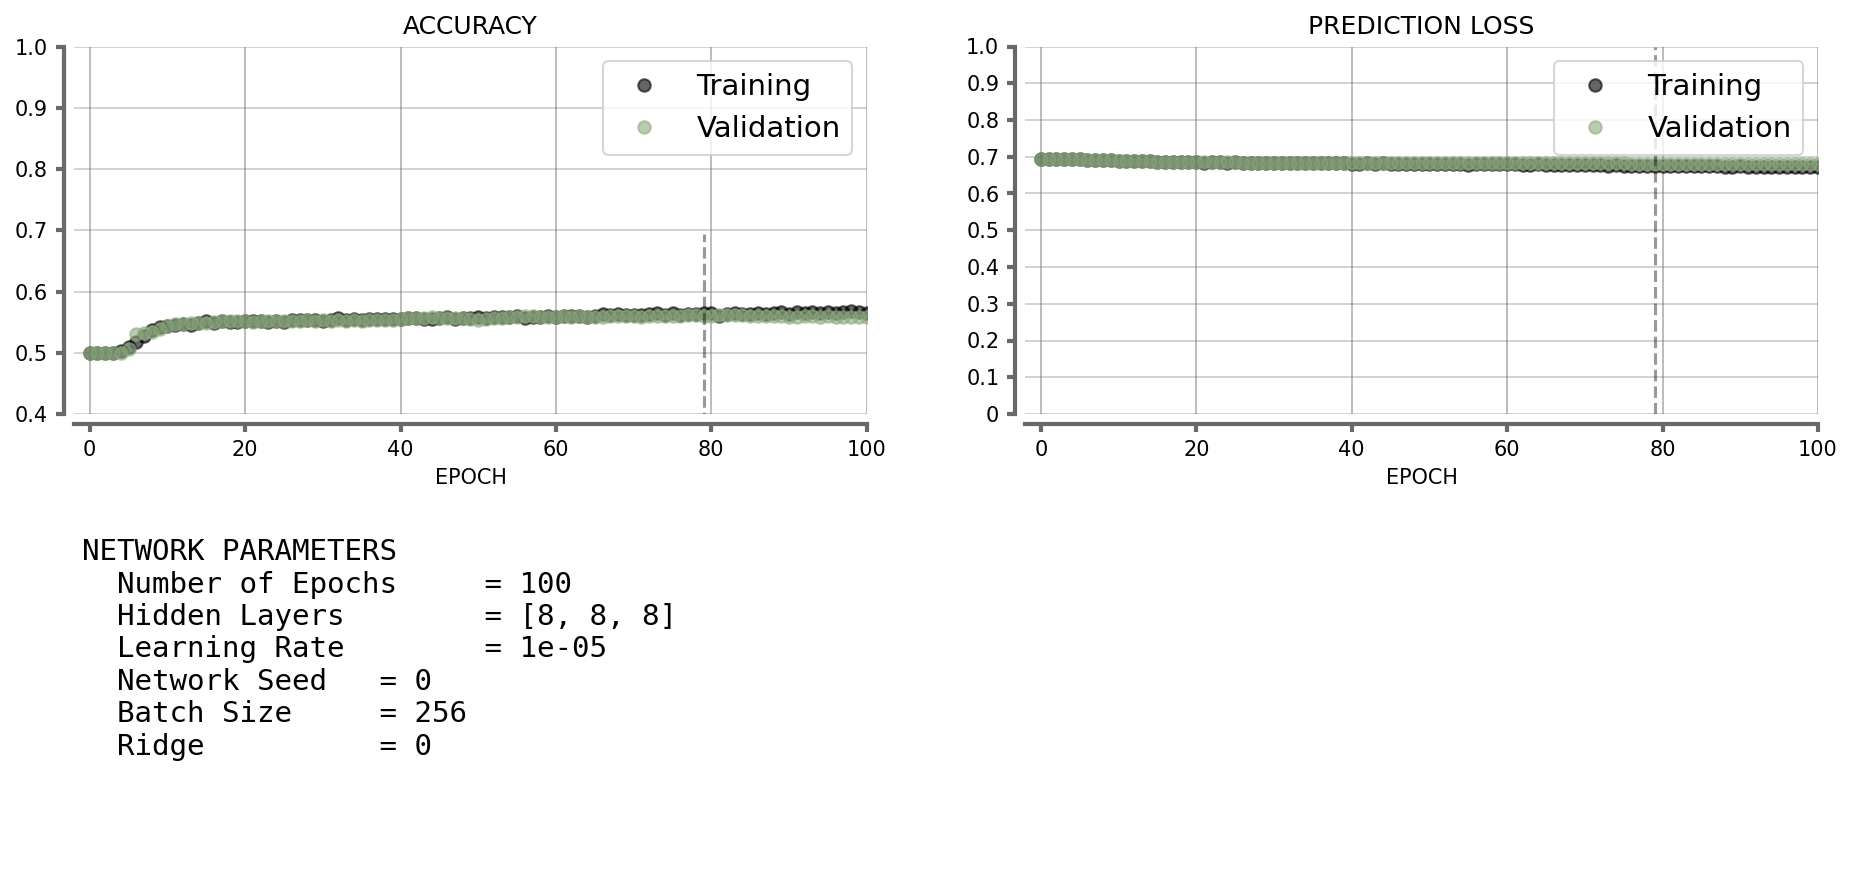

243/243 [==============================] - 0s 909us/step
55.579896907216494
56.06958762886598
1
Elapsed time during fit = 62.87 seconds



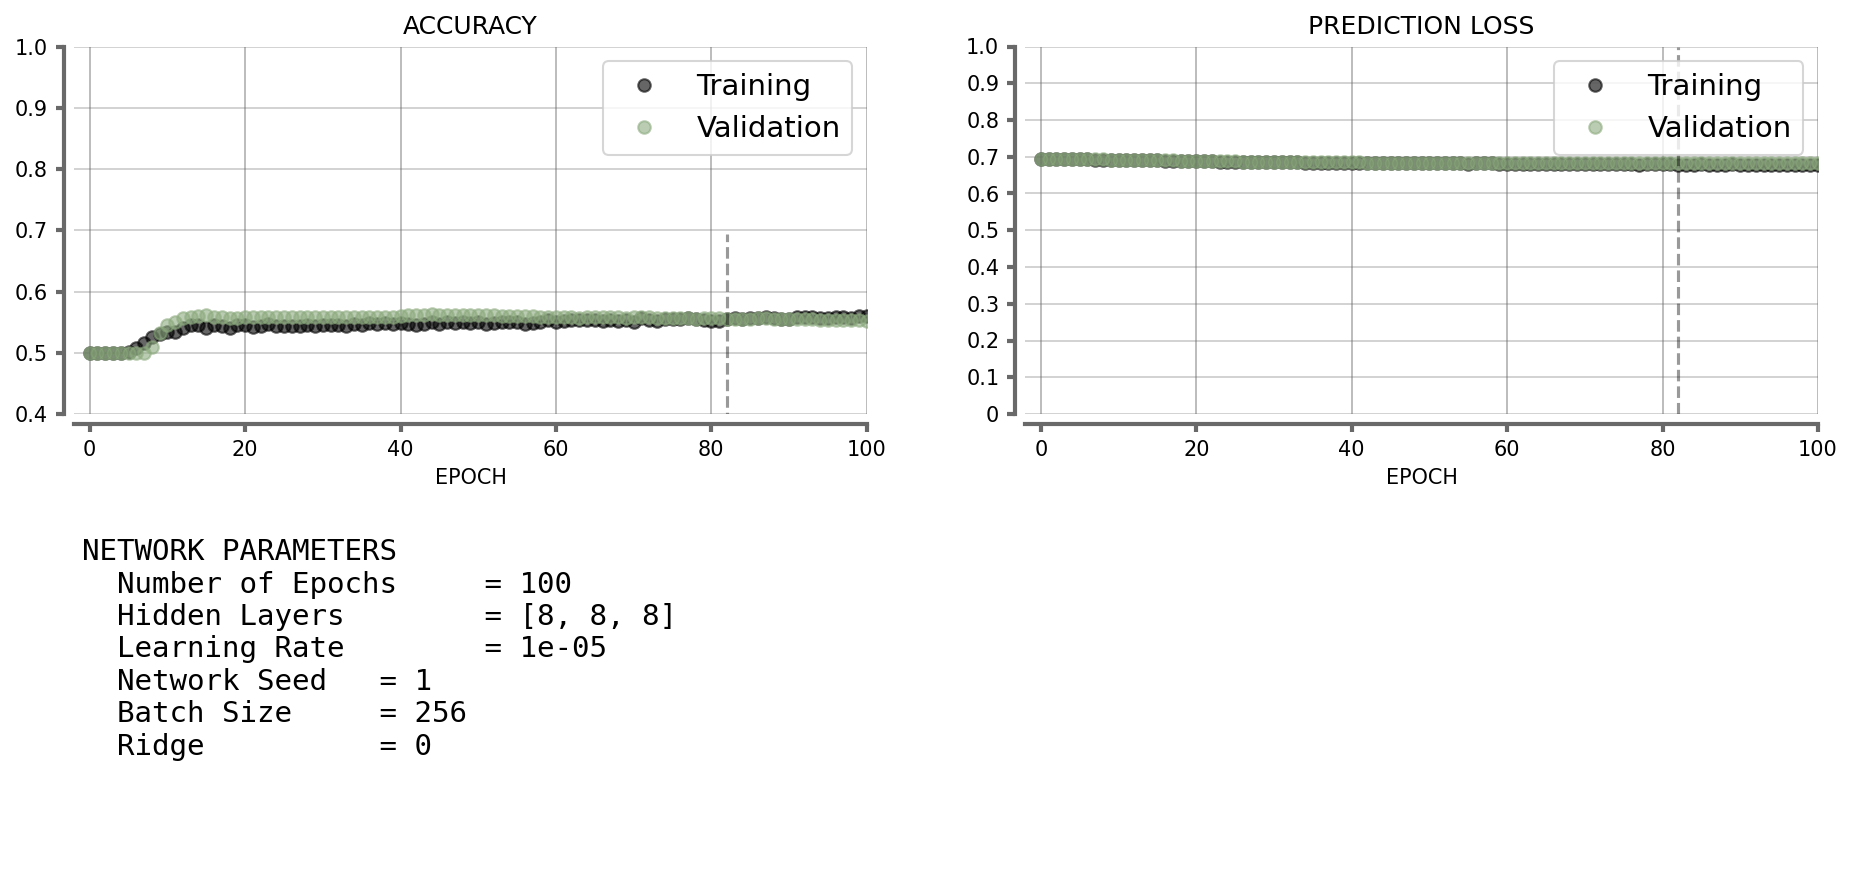

243/243 [==============================] - 0s 524us/step
55.48969072164949
55.4639175257732
CPU times: user 1min 49s, sys: 2.42 s, total: 1min 51s
Wall time: 2min 53s


In [6]:
%%time
# ---------- ANN Hyperparameters ----------
NLABEL = 2
N_EPOCHS = 1000

hps = get_hp(EXP_NAME) # need to have this here because .extend overwrites HIDDENS

HIDDENS = hps['HIDDENS']
GLOBAL_SEED = hps['GLOBAL_SEED']

# HIDDENS.extend(hps2['ADD_HIDDENS'])
HIDDENS.extend([8,8])
ann2LR_INIT = 0.00001#hps2['LR_INIT'] 
ann2BATCH_SIZE = 256 #hps2['BATCH_SIZE'] 
ann2dropout_rate = 0.85 #hps2['DROPOUT_RATE'] 
dropout_bool = True
ann2RIDGE = 0 #hps2['RIDGE'] 
PATIENCE = hps2['PATIENCE']

#----- SET UP & TRAIN NN -----
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

for SEED in range(2):
    print(SEED)
    tf.keras.backend.clear_session() 

    # ------ define NN ------
    ann2 = create_ann2(input_shape = input_shape,
                       output_shape = NLABEL,
                       hiddens=HIDDENS,
                       RIDGE = ann2RIDGE,
                       dropout = dropout_bool, dropout_rate = ann2dropout_rate)

    annfi_name = 'ann_60Eshift_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann1 = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)

    ## For exp1:
    # for l in [1]:#,3]: #layers 1 & 3 have weights in ann1 (4 also has weight but we are removing final layer); layer 2 is dropout
    #     ann2.layers[l].set_weights(ann1.layers[l].get_weights()) #[:-1*(len(ann2HIDDENS)+1)][l].set_weights(ann1.layers[:-1][l].get_weights())
    #     # ann2.layers[:-1*(len(ann2HIDDENS)+1)][l].trainable = False

    ann2.layers[1].set_weights(ann1.layers[1].get_weights())

    # ann2.summary()

    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate = ann2LR_INIT,)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    ann2.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)

    # ----- Callbacks -----
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    # LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)

    # ------ Train -----
    start_time = time.time()
    history = ann2.fit(X2train,Y2train,
                      validation_data = [X2val,Y2val],
                      batch_size = ann2BATCH_SIZE,
                      epochs = N_EPOCHS,
                      shuffle = True,
                      verbose = 0,
                      callbacks = [ES])#,LR])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")

    #----- PLOT THE RESULTS -----
    plot_results(
        history,
        exp_info=(100, HIDDENS, ann2LR_INIT, ann2BATCH_SIZE, SEED, PATIENCE, ann2RIDGE),
        showplot=True
    ) 
    
    pred1 = np.argmax(ann1.predict(X2val),axis=-1)
    pred2 = np.argmax(ann2.predict(X2val),axis=-1)
    print((np.shape(np.where(pred1==Y2val)[0])[0]/np.shape(Y2val)[0])*100) # og network 
    print((np.shape(np.where(pred2==Y2val)[0])[0]/np.shape(Y2val)[0])*100) # first layer weights transferred 